# Practica 3

**Objetivo:** Realizar un reconocimiento de Entidades Nombradas (NER) a partir de un modelo
secuencial y con el corpus [ner_dataset.csv](./../99_corpus/ner_dataset.csv) que
se proporciona.

In [1]:
# Bibliotecas de apoyo
import csv
from unicodedata import normalize
from collections import Counter, defaultdict
from itertools import chain, product
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/penserbjorne/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/penserbjorne/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
# Funciones de apoyo

# Definimos funcion de apoyo para imprimir ejemplos de los corpus
def ejemplos(msg, collection, n_elements):
    print(msg)
    for element in collection[:n_elements]:
        print(element)
        
# Funcion que crea un vocabulario de palabras con un indice numerico
def vocab():
    vocab = defaultdict()
    vocab.default_factory = lambda: len(vocab)
    return vocab    

# Funcion que pasa la cadena de simbolos a una secuencia con indices numericos
def text2numba(corpus, vocab):
    for doc in corpus:
        yield [vocab[w] for w in doc.strip().split()]

# Funcion para graficar el arbol del etiquetado POS
def view_pos_graph(ob, em):
    transit = list(zip( em.split(),em.split()[1:] ))
    ejemplo = list(zip( ob.split(),em.split() ))

    #Grafiacación del grafo de la oración
    G = nx.Graph()
    G.add_edges_from(ejemplo+transit)

    nx.draw_spectral(G, with_labels=True, node_size=1)
    plt.show()

Como propuesta de solución se ha optado por trabajar con los **Modelos Ocultos de Markov**

Podemos entender un modelo oculto de Markov como la tupla: $HMM = (O, S, A, \Pi, B)$

Donde:

- $O$ es el alfabeto de observaciones
- $S$ el alfabeto de emisiones
- ($ A, \Pi$) un modelo del lenguaje sobre $S$
- $B$ la matriz de probabilidades de emisión.

La idea es encontrar una función que sea capaz de mapear cadenas en un lenguaje $L_1$
a un lenguaje $L_2$. En este sentido, el primer lenguaje son frases en ingles y el 
segundo corresponde a las cadenas de **Entidades Nombradas**.

## 1. Obtención y preprocesamiento del texto.

In [3]:
# Abrir el documento
document = './../99_corpus/ner_dataset.csv'
doc_content = open(document, 'r', encoding='utf-8')
reader = csv.reader(doc_content)
doc_content_list = list(reader)

In [4]:
# Extraer sentencias del documento

# Trabajaremos con dos grupos de cadenas
obs = [] # Las cadenas de observación
ems = [] # Las emisiones (etiquetas)
ob = ""  # Variable temporal para una sentencia de observacion
em = ""  # Variable temporal para una emision

# Hay observaciones que no estan eqtiquetadas, esas observaciones
# No las vamos a contar en el conjunto de "entrenamiento"
# Si no que las mandaremos al conjunto de prueba

test = []  # Cadenas de prueba

# Variables de apoyo para identificar las observaciones no etiquetadas
cont_em = 0
cont_ob = 0

# Trabajamos con filas en el documento
# Comenzando por la segunda ya que la primera son encabezados
for row in doc_content_list[1:]:
    # Detectamos que es el inicio de una sentencia nueva, hay 
    # que guardar la sentencia anterior
    if row[0] is not '' and ob is not "":
        # Normalizamos la sentencia y la convertimos a minusculas
        ob = normalize('NFKC', ob).lower()
        
        # Verificamos que la observacion si haya estado 
        # etiquetada, si es asi la consideramos en el 
        # conjunto de entrenamiento
        if not cont_em == cont_ob:
            obs.append(ob)
            ems.append(em)
        else:
        # Si no es asi la consideramos en el conjutno de prueba
            test.append(ob)
        
        # Limpiamos variables de apoyo
        ob = ""
        em = ""
        cont_ob = 0
        cont_em = 0
        
    # No queremos estos caracteres porque meten ruido T_T
    if row[1] != "" and row[1] != '' and row[1] != '$' and row[1] != '.' and row[1] != ',':
        # Creaamos la sentencia de observación
        ob = ob + row[1] + " "
        cont_ob = cont_ob + 1

        # Creamos la sentencia de emision
        # Si el token no esta vacio, lo podemos añadir a la sentencia
        if len(row[2]) > 0:
            em = em + row[2] + " "
        else:
        # Si el token esta vacio añadimos una etiqueta que la identifique
            em = em + "UNK" + " "
            cont_em = cont_em + 1

# Agregamos la ultima sentencia
ob = normalize('NFKC', ob).lower()
if not (cont_em == cont_ob):
    obs.append(ob)
    ems.append(em)
else:
    test.append(ob)

In [5]:
print("### Cantidad de observaciones: ", len(obs))
ejemplos("### Observaciones ###", obs, 5)
print()
print("### Cantidad de emisiones: ", len(ems))
ejemplos("### Emision ###", ems, 5)
print()
print("### Cantidad de pruebas: ", len(test))
ejemplos("### Pruebas ###", test, 5)

### Cantidad de observaciones:  849
### Observaciones ###
thousands of demonstrators have marched through london to protest the war in iraq and demand the withdrawal of british troops from that country 
families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as " bush number one terrorist " and " stop the bombings " 
they marched from the houses of parliament to a rally in hyde park 
the protest comes on the eve of the annual conference of britain 's ruling labor party in the southern english seaside resort of brighton 
the party is divided over britain 's participation in the iraq conflict and the continued deployment of 8500 british troops in that country 

### Cantidad de emisiones:  849
### Emision ###
UNK UNK UNK UNK UNK UNK B-ge UNK UNK UNK UNK UNK B-ge UNK UNK UNK UNK UNK B-gpe UNK UNK UNK UNK 
UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK B-per UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK 
UNK UNK UNK UNK UNK 

Como podemos observar, hay demasiadas etiquetas UNK, lo cual meterá bastante ruido al etiquetado (lo puedo afirmar, llevo días peleando con esto T_T), por lo cual haremos algo (que tal vez es trampa o una cochinada, perdon Victli), un etiquetado POS en el corpus y respetaremos el etiquetado de entidades que ya existia.

In [6]:
# Iteramos sobre las observaciones
for i in range(len(obs)):
    # Tokenizamos
    l_ob = obs[i].split()
    l_em = ems[i].split()
    # Etiquetamos POS
    t_pos = nltk.pos_tag(l_ob)
    new_em = ""
    cont = 0
    # Creamos las nuevas emisiones coformadas por el 
    # etiquetado POS y el etiquetado de entidades 
    # original
    for em in l_em:
        if em == 'UNK':
            new_em = new_em + t_pos[cont][1] + " "
        else:
            new_em = new_em + em + " "
        cont = cont + 1
    ems[i] = new_em

In [7]:
print("### Cantidad de observaciones: ", len(obs))
ejemplos("### Observaciones ###", obs, 5)
print()
print("### Cantidad de emisiones: ", len(ems))
ejemplos("### Emision ###", ems, 5)
print()
print("### Cantidad de pruebas: ", len(test))
ejemplos("### Pruebas ###", test, 5)

### Cantidad de observaciones:  849
### Observaciones ###
thousands of demonstrators have marched through london to protest the war in iraq and demand the withdrawal of british troops from that country 
families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as " bush number one terrorist " and " stop the bombings " 
they marched from the houses of parliament to a rally in hyde park 
the protest comes on the eve of the annual conference of britain 's ruling labor party in the southern english seaside resort of brighton 
the party is divided over britain 's participation in the iraq conflict and the continued deployment of 8500 british troops in that country 

### Cantidad de emisiones:  849
### Emision ###
NNS IN NNS VBP VBN IN B-ge TO VB DT NN IN B-ge CC NN DT NN IN B-gpe NNS IN DT NN 
NNS IN NNS VBN IN DT NN VBD DT NNS WP VBD NNS IN JJ NNS IN JJ B-per NN CD NN NN CC NNP VB DT NNS VBP 
PRP VBD IN DT NNS IN NN TO DT NN IN B-ge I-ge 
DT NN

Como podemos observar, en teoria el ruido deberia de disminuir. 
Debido a resultados del proyecto sabemos que la mayoria de las sentencias quedaban etiquetadas como UNK UNK ... UNK UNK , nuca se llegaba a etiquetar correctamente, esto era debido a la frecuencias de apariciones que tenia UNK.

Aún así, hay que seguir limpiando el corpus, necesitamos sustituir las palabras de etiquetas $<UNK>$ en el corpus.

In [8]:
# Definamos una función para sustituir los hapax, esta funcion recibe un corpus
def replace_hapax(corpus):
    UNK = '<UNK>'
    # Obtenemos las frecuencias de las palabras del corpus
    txt = ""
    for line in corpus:
        txt += line
    freqs = Counter(txt.split())
    #print(freqs)

    # Sustituimos los hápax por UNK en las palabras con frecuencia = 1
    corpus_unk = []

    for line in corpus:
        new_line = ""
        for word in line.split():
            # Si la frecuencia de la palabra = 1, es un hapáx
            if freqs[word] == 1:
                new_line = new_line + UNK + " "
            # Si no, añadimos la palabra original
            else:
                new_line = new_line + word + " "
        corpus_unk.append(new_line)
    return corpus_unk

In [9]:
# Limpiamos hapax
corpus = obs.copy()
corpus.extend(test)
corpus_unk = replace_hapax(corpus)

obs = []
test = []

obs = corpus_unk[:len(ems)]
test = corpus_unk[len(ems):]

In [10]:
print("### Cantidad de observaciones: ", len(obs))
ejemplos("### Observaciones ###", obs, 5)
print()
print("### Cantidad de emisiones: ", len(ems))
ejemplos("### Emision ###", ems, 5)
print()
print("### Cantidad de pruebas: ", len(test))
ejemplos("### Pruebas ###", test, 5)

### Cantidad de observaciones:  849
### Observaciones ###
thousands of demonstrators have marched through london to protest the war in iraq and demand the withdrawal of british troops from that country 
families of soldiers killed in the conflict joined the protesters who carried <UNK> with such slogans as " bush number one terrorist " and " stop the bombings " 
they marched from the houses of parliament to a rally in <UNK> <UNK> 
the protest comes on the eve of the annual conference of britain 's ruling labor party in the southern english <UNK> <UNK> of <UNK> 
the party is divided over britain 's <UNK> in the iraq conflict and the continued deployment of <UNK> british troops in that country 

### Cantidad de emisiones:  849
### Emision ###
NNS IN NNS VBP VBN IN B-ge TO VB DT NN IN B-ge CC NN DT NN IN B-gpe NNS IN DT NN 
NNS IN NNS VBN IN DT NN VBD DT NNS WP VBD NNS IN JJ NNS IN JJ B-per NN CD NN NN CC NNP VB DT NNS VBP 
PRP VBD IN DT NNS IN NN TO DT NN IN B-ge I-ge 
DT NN VBZ IN DT NN

In [11]:
# Nos pidieron separar el corpus en 70% entrenamiento y 30% evaluación
per_train = .7

total_sentences = len(obs) + len(test)
total_train = int(total_sentences * per_train)

if total_train < len(obs):
    test.extend(obs[total_train:])
    del obs[total_train:]
    del ems[total_train:]
else:
    print("Las sentencias etiquetadas son menores o iguales al 70% del corpus total, dejaremos el tamaño de los corpus como estan.\n")

print("Tamaño del corpus de entrenamiento: ", len(obs))
print("Tamaño del corpus de evaluacion: ", len(test))

Tamaño del corpus de entrenamiento:  700
Tamaño del corpus de evaluacion:  300


# 2. Obtención de los vocabularios (alfabetos)

Ahora tenemos que indicar cuáles son las observaciones y cuáles los símbolos de emisión. Asimimso, asignaremos sus frecuencias y las probabilidades iniciales.

In [12]:
# Vocabulario de observaciones
obs_voc = vocab()
obs_cads = list(text2numba(obs,obs_voc))
print("Cantidad de tokens: ", len(obs_voc))
print("Cantidad de cadenas: ", len(obs_cads))
#print(obs_voc)

Cantidad de tokens:  1894
Cantidad de cadenas:  700


In [13]:
# Vocabulario de emisiones
ems_voc = vocab()
ems_cads = list(text2numba(ems,ems_voc))
print("Cantidad de etiquetas: ", len(ems_voc))
print("Cantidad de cadenas: ", len(ems_cads))
print("Etiquetas: ", ems_voc)

Cantidad de etiquetas:  51
Cantidad de cadenas:  700
Etiquetas:  defaultdict(<function vocab.<locals>.<lambda> at 0x7f82440b8050>, {'NNS': 0, 'IN': 1, 'VBP': 2, 'VBN': 3, 'B-ge': 4, 'TO': 5, 'VB': 6, 'DT': 7, 'NN': 8, 'CC': 9, 'B-gpe': 10, 'VBD': 11, 'WP': 12, 'JJ': 13, 'B-per': 14, 'CD': 15, 'NNP': 16, 'PRP': 17, 'I-ge': 18, 'VBZ': 19, 'POS': 20, 'B-rg': 21, 'I-rg': 22, 'RB': 23, 'VBG': 24, 'B-tim': 25, 'WRB': 26, 'PRP$': 27, 'WDT': 28, 'MD': 29, 'B-art': 30, 'I-art': 31, 'I-per': 32, 'JJR': 33, ':': 34, 'JJS': 35, 'WP$': 36, 'RP': 37, 'PDT': 38, 'I-gpe': 39, 'I-tim': 40, 'EX': 41, 'RBS': 42, '(': 43, ')': 44, 'B-nat': 45, 'RBR': 46, 'B-eve': 47, 'I-eve': 48, 'I-nat': 49, '.': 50})


Para obtener la matriz $B$ de probabilidades de emisión, requerimos saber que observaciones son generadas por qué emisiones. Para esto obtendremos pares de la forma $(o_i,s_j)$ con $o_i \in O$ y $s_j \in S$. Esto es, si la observación $o_i$ está etiquetado con la emisión $s_j$ entonces lo tomaremos como un par de este conjunto.

In [14]:
# Pares de observaciones y sus etiquetas
obs_ems = list(chain(*[list(zip(c[0],c[1])) for c in zip(obs_cads,ems_cads)]))
print("Cantidad de bigramas: ", len(obs_ems))
#print(obs_ems)

Cantidad de bigramas:  14930


Asimismo, para crear el modelo del lenguaje sobre $S$ requerimos llenar la matriz $A$ y el vector $\Pi$, para esto, a cada cadena de símbolos de emisión se le agregan los símbolos de inicio $<BOS>$ y final $<EOS>$.

In [15]:
# Indicamos las etiquetas de sentencia a usar
BOS = '<BOS>'
EOS = '<EOS>'

# Cada etiqueta se le asigna un indice numerico
BOS_IDX = max(ems_voc.values())+2
EOS_IDX = max(ems_voc.values())+1

# Se agregan estas etiquetas al vocabulario
ems_voc[BOS] = BOS_IDX
ems_voc[EOS] = EOS_IDX

# A cada cadena se le agrega la etiqueta BOS al inicio y EOS al final
ems_cads = [[BOS_IDX] + cad + [EOS_IDX] for cad in ems_cads]

ejemplos("### Cadenas de emisiones indexadas ###", ems_cads, 5)

### Cadenas de emisiones indexadas ###
[52, 0, 1, 0, 2, 3, 1, 4, 5, 6, 7, 8, 1, 4, 9, 8, 7, 8, 1, 10, 0, 1, 7, 8, 51]
[52, 0, 1, 0, 3, 1, 7, 8, 11, 7, 0, 12, 11, 0, 1, 13, 0, 1, 13, 14, 8, 15, 8, 8, 9, 16, 6, 7, 0, 2, 51]
[52, 17, 11, 1, 7, 0, 1, 8, 5, 7, 8, 1, 4, 18, 51]
[52, 7, 8, 19, 1, 7, 8, 1, 7, 13, 8, 1, 4, 20, 8, 21, 22, 1, 7, 13, 10, 8, 8, 1, 4, 51]
[52, 7, 8, 19, 3, 1, 10, 20, 8, 1, 7, 4, 8, 9, 7, 13, 8, 1, 15, 10, 0, 1, 7, 8, 51]


A partir de las cadenas de emisiones (que pertenencen a $S^∗$) obtenemos los bigramas que se atestiguaron en el corpus.

In [16]:
# Bigramas a partir de las cadenas de emisiones
ems_bigrams = list(chain(*[ zip(cad,cad[1:]) for cad in ems_cads] ))

print("Cantidad de bigramas a partir de las emisiones: ", len(ems_bigrams))
#ejemplos("### Bigramas a partir de las emisiones ###", ems_bigrams, 15)

Cantidad de bigramas a partir de las emisiones:  15630


# 3. Estimación del modelo oculto de Markov

Una vez obtenido los vocabularios, así como sus indices, así como los pares de observaciones y sus emisiones y los bigramas de emisiones, podemos determinar el modelo; es decir, estimaremos las probabilidades que llenarán las marices $A$, $\Pi$ y $B$.

In [17]:
# Longitud del vocabulario de emisiones
N = len(ems_voc)
# Longitud del vocabulario de observaciones
M = len(obs_voc)

# ems language model
Pi = np.zeros(N-2)
A = np.zeros((N-2,N-1))

# Prob ems
B = np.zeros((M,N-2))

Para obtener el modelo del lenguaje sobre $S$ estimaremos los siguientes elementos:

- La matriz de transiciones:
$$A=(a_{ij}) = p(s_j|s_i)  = \frac{\#(s_i s_j)+1}{\#(s_i) + N}$$

- El vector de iniciales:
$$\Pi = (\pi_{i}) = p(s_i|<BOS>) = \frac{\#(<BOS> s_i)+1}{\#(<BOS>)+N}$$

In [18]:
# Frecuencia de bigramas de emisiones
frec_ems = Counter(ems_bigrams)
#print(frec_ems)

# Llenado de las frecuencias
for em, frec_em in frec_ems.items():
    if em[0] == BOS_IDX:
        Pi[em[1]] = frec_em
    else:
        A[em] = frec_em

In [19]:
# Sommothing
A = ((A.T+1)/(A+1).sum(1)).T
Pi = (Pi+1)/(Pi+1).sum(0)

In [20]:
print(A)
print()
print(Pi)

[[0.01618123 0.30339806 0.13754045 ... 0.00080906 0.00080906 0.12135922]
 [0.05361791 0.01769912 0.00104112 ... 0.00052056 0.00052056 0.00052056]
 [0.04012346 0.05864198 0.00617284 ... 0.00308642 0.00308642 0.01851852]
 ...
 [0.03125    0.046875   0.015625   ... 0.015625   0.015625   0.03125   ]
 [0.01754386 0.01754386 0.01754386 ... 0.05263158 0.01754386 0.03508772]
 [0.01886792 0.01886792 0.01886792 ... 0.01886792 0.01886792 0.03773585]]

[0.07856192 0.06391478 0.00266312 0.00399467 0.03728362 0.00133156
 0.00266312 0.2942743  0.03328895 0.01198402 0.13315579 0.00133156
 0.00133156 0.03328895 0.08255659 0.01331558 0.00133156 0.04793609
 0.00133156 0.00133156 0.00133156 0.04660453 0.00133156 0.03195739
 0.00798935 0.00798935 0.00266312 0.00266312 0.00133156 0.00133156
 0.00133156 0.00133156 0.00133156 0.00798935 0.00133156 0.00266312
 0.00133156 0.00133156 0.00133156 0.00133156 0.00133156 0.00266312
 0.00133156 0.00133156 0.00133156 0.00133156 0.01198402 0.00133156
 0.00133156 0.00133

In [21]:
# Comprobar que las sumas sean 1
print(A.sum(1))
print(Pi.sum(0))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
0.9999999999999999


Para obtener la matriz $B$, usaremos la siguiente función:

$$B = (b_{ij}) = p(o_j|s_i) = \frac{\#(o_j, s_i)+1}{\#(s_i)+M}$$

In [22]:
# Frecuencia de pares de observaciones y emisiones
frec_obs = Counter(obs_ems)

# Llenado con las frecuencias
for ob, frec_ob in frec_obs.items():
    B[ob] = frec_ob

In [23]:
# Smoothing
B = ((B+1).T/(B+1).sum(1)).T

In [24]:
print(B)

[[0.13793103 0.01724138 0.01724138 ... 0.01724138 0.01724138 0.01724138]
 [0.00221729 0.85365854 0.00221729 ... 0.00221729 0.00221729 0.00221729]
 [0.07407407 0.01851852 0.01851852 ... 0.01851852 0.01851852 0.01851852]
 ...
 [0.05660377 0.01886792 0.01886792 ... 0.01886792 0.01886792 0.01886792]
 [0.01886792 0.01886792 0.01886792 ... 0.01886792 0.01886792 0.01886792]
 [0.01923077 0.03846154 0.01923077 ... 0.01923077 0.01923077 0.01923077]]


In [25]:
# Comprobar que se sume 1
print(B.sum(1))

[1. 1. 1. ... 1. 1. 1.]


# 4. Algoritmo de Viterbi

El algoritmo de Viterbi permite encontrar, de manera dinámica, la serie de etiquetas que describan mejor a la cadena de entrada.

In [26]:
class Viterbi:
    # Constructor del objeto
    def __init__(self, N, B, A, Pi, obs_voc, ems_voc):
        self.N = N
        self.B = B
        self.A = A
        self.Pi = Pi
        self.obs_voc = obs_voc
        self.ems_voc = ems_voc
        
    # Inicializamos parametros del algoritmo
    def initialize_params(self, O):
        # Cadena de entrada
        self.O = O
        
        # Separa la cadena
        self.cadO = self.O.split()
        # Longitud de la cadena
        self.T = len(self.cadO)
        
        # Matrices para el avance y el retroceso:
        #Variable delta
        self.d = np.zeros((self.T,self.N))
        #Variable phi
        self.phi = np.zeros((self.T,self.N))
        
    # Aqui se ejecuta el algoritmo con el forward y el backward
    def do_your_work(self):
        # FORWARD
        # Inicialización
        self.d[0] = self.B[self.obs_voc[self.cadO[0]]] * self.Pi
        
        #Inducción
        for t in range(self.T-1):
            # Indice de la palabra
            w = self.obs_voc[self.cadO[t+1]]
            
            # Productos
            prod = (self.B[w] * self.A[:,:self.N]) * self.d[t]
            
            # Guarda variables delta
            self.d[t+1] = np.max(prod, axis=0)
            
            # Guarda variables phi
            self.phi[t+1] = np.argmax(prod, axis=0)

        # BACKWARD
        # Inicialización
        j = np.argmax(self.d[self.T-1])
        etiqs = [list(self.ems_voc.keys())[j]]
        
        # Inducción
        for t in range(self.T-1):
            
            # Indices de retroceso
            k = self.T-1-t
            
            # Argmax camino
            j = int(self.phi[k][j])
            
            # Guarda etiquetas
            etiqs.append(list(self.ems_voc.keys())[j])

        #Ordena etiquetas
        etiqs.reverse()

        return etiqs

In [27]:
MyViterbi = Viterbi(N-2, B, A, Pi, obs_voc, ems_voc)

Probemos con sentencias que estaban etiquetadas :S

Cadena:  thousands of demonstrators have marched through london to protest the war in iraq and demand the withdrawal of british troops from that country  

Etiquetas correctas:  NNS IN NNS VBP VBN IN B-ge TO VB DT NN IN B-ge CC NN DT NN IN B-gpe NNS IN DT NN  

Etiquetas propuestas:  WRB PRP VBZ VBN IN B-tim WRB PRP VBZ VBN IN B-tim WRB PRP VBZ VBN IN B-tim WRB PRP VBZ VBN IN 

Arbol correcto


/home/penserbjorne/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


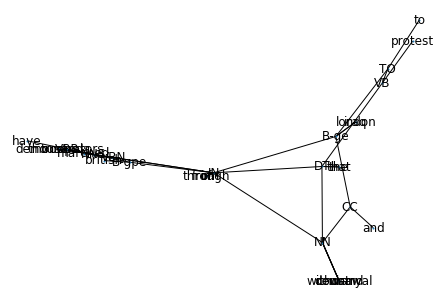

Arbol propuesto


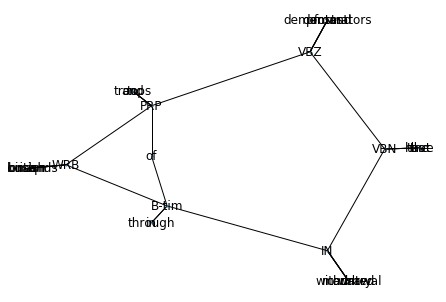

In [28]:
MyViterbi.initialize_params(obs[0])
etiquetas = MyViterbi.do_your_work()
print("Cadena: ", obs[0], "\n")
print("Etiquetas correctas: ", ems[0], "\n")
print("Etiquetas propuestas: ", ' '.join(etiquetas), "\n")
print("Arbol correcto")
view_pos_graph(obs[0], ems[0])
print("Arbol propuesto")
view_pos_graph(obs[0], ' '.join(etiquetas))

Cadena:  families of soldiers killed in the conflict joined the protesters who carried <UNK> with such slogans as " bush number one terrorist " and " stop the bombings "  

Etiquetas correctas:  NNS IN NNS VBN IN DT NN VBD DT NNS WP VBD NNS IN JJ NNS IN JJ B-per NN CD NN NN CC NNP VB DT NNS VBP  

Etiquetas propuestas:  IN B-tim WRB PRP VBZ VBN IN B-tim WRB PRP VBZ VBN IN B-tim WRB PRP VBZ VBN IN B-tim WRB PRP VBZ VBN IN B-ge POS JJ NN 

Arbol correcto


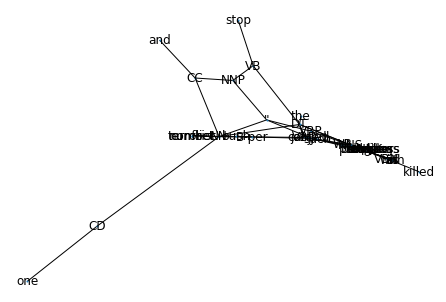

Arbol propuesto


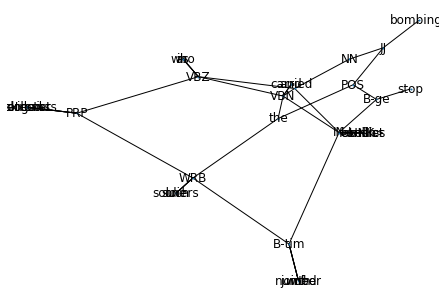

In [29]:
MyViterbi.initialize_params(obs[1])
etiquetas = MyViterbi.do_your_work()
print("Cadena: ", obs[1], "\n")
print("Etiquetas correctas: ", ems[1], "\n")
print("Etiquetas propuestas: ", ' '.join(etiquetas), "\n")
print("Arbol correcto")
view_pos_graph(obs[1], ems[1])
print("Arbol propuesto")
view_pos_graph(obs[1], ' '.join(etiquetas))

Cadena:  they marched from the houses of parliament to a rally in <UNK> <UNK>  

Etiquetas correctas:  PRP VBD IN DT NNS IN NN TO DT NN IN B-ge I-ge  

Etiquetas propuestas:  IN B-tim WRB PRP VBZ VBN IN B-tim WRB PRP VBZ VBN IN 

Arbol correcto


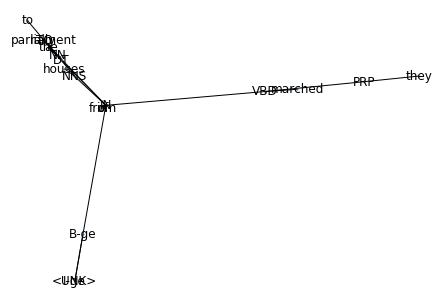

Arbol propuesto


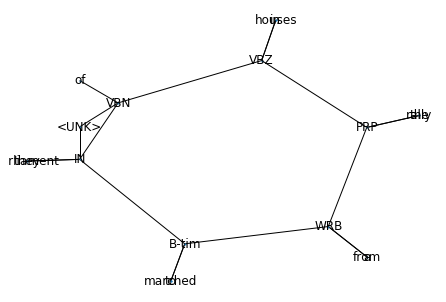

In [30]:
MyViterbi.initialize_params(obs[2])
etiquetas = MyViterbi.do_your_work()
print("Cadena: ", obs[2], "\n")
print("Etiquetas correctas: ", ems[2], "\n")
print("Etiquetas propuestas: ", ' '.join(etiquetas), "\n")
print("Arbol correcto")
view_pos_graph(obs[2], ems[2])
print("Arbol propuesto")
view_pos_graph(obs[2], ' '.join(etiquetas))

Como podemos observar, esto no funciona :'(

Las etiquetas no son (ni de cerca) correctas.

Probemos con sentencias que no estaban etiquetadas :'(

Cadena:  the step will allow the facility to operate at full capacity  

Etiquetas propuestas:  PRP VBZ VBN IN B-tim WRB PRP VBZ VBN IN DT 

Arbol propuesto


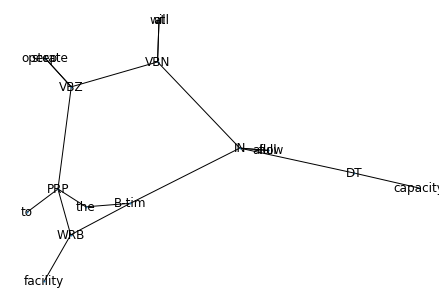

In [31]:
MyViterbi.initialize_params(test[1])
etiquetas = MyViterbi.do_your_work()
print("Cadena: ", test[1], "\n")
print("Etiquetas propuestas: ", ' '.join(etiquetas), "\n")
print("Arbol propuesto")
view_pos_graph(test[1], ' '.join(etiquetas))

Cadena:  the provincial governor must still sign the bill before it <UNK> law a step seen only as a <UNK>  

Etiquetas propuestas:  B-tim WRB PRP VBZ VBN IN B-tim WRB PRP VBZ VBN IN B-tim WRB PRP VBZ VBN IN DT 

Arbol propuesto


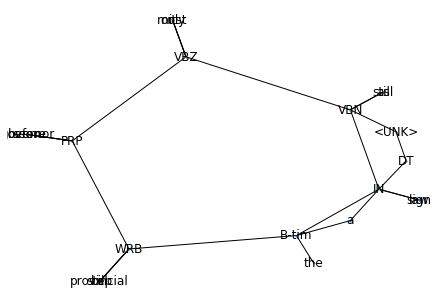

In [32]:
MyViterbi.initialize_params(test[2])
etiquetas = MyViterbi.do_your_work()
print("Cadena: ", test[2], "\n")
print("Etiquetas propuestas: ", ' '.join(etiquetas), "\n")
print("Arbol propuesto")
view_pos_graph(test[2], ' '.join(etiquetas))

Cadena:  <UNK> could be jailed for up to six months  

Etiquetas propuestas:  PRP VBZ VBN IN B-ge POS JJS CD NNS 

Arbol propuesto


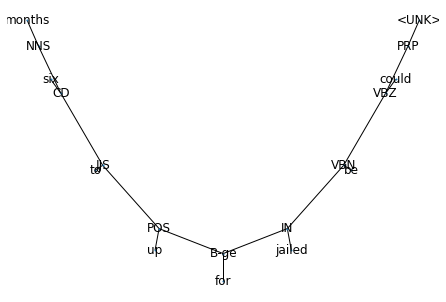

In [33]:
MyViterbi.initialize_params(test[3])
etiquetas = MyViterbi.do_your_work()
print("Cadena: ", test[3], "\n")
print("Etiquetas propuestas: ", ' '.join(etiquetas), "\n")
print("Arbol propuesto")
view_pos_graph(test[3], ' '.join(etiquetas))

Cadena:  his driver and a tribal <UNK> were also killed  

Etiquetas propuestas:  WRB PRP VBZ VBN IN B-ge POS JJ NN 

Arbol propuesto


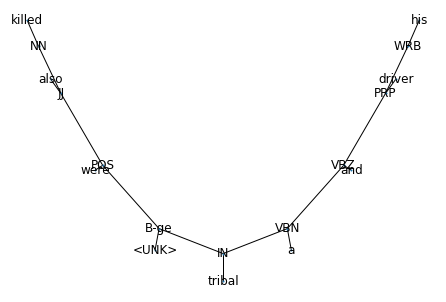

In [34]:
MyViterbi.initialize_params(test[4])
etiquetas = MyViterbi.do_your_work()
print("Cadena: ", test[4], "\n")
print("Etiquetas propuestas: ", ' '.join(etiquetas), "\n")
print("Arbol propuesto")
view_pos_graph(test[4], ' '.join(etiquetas))

Cadena:  no one has claimed responsibility for the killings  

Etiquetas propuestas:  IN B-tim WRB PRP VBZ VBN IN DT 

Arbol propuesto


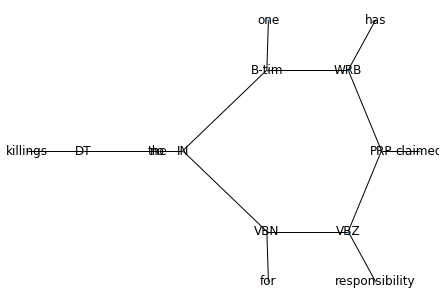

In [35]:
MyViterbi.initialize_params(test[5])
etiquetas = MyViterbi.do_your_work()
print("Cadena: ", test[5], "\n")
print("Etiquetas propuestas: ", ' '.join(etiquetas), "\n")
print("Arbol propuesto")
view_pos_graph(test[5], ' '.join(etiquetas))

Bueno ... el uso de HMM para etiquetado POS o NER al parecer en este caso no fue demasiado bueno ... chale :'(

# Conclusiones

Bueno, ya llevo varios días de retraso, tratando de darle vueltas al HMM y empeñado con esto, puede que tal vez en esta ocasion este no sea el mejor abordaje.

Como se puede observar en los resultados , aunque se opto por utilizar un corpus pre etiquetado mediante POS con nltk, aún asi los resultados son desastrosos.

Sinceramente no sé cual fue la parte que salio mal, los vectores y matrices de probabilidades se ven bien, ¿habra sido el etiquetado? ¿Habra sido el algoritmo de Viterbi? No lo sé ...

Tal vez hubiera sido mejor abordarlo con otro modelo, tal vez uno basado en redes neuronales :'( lo siento T_T

![no se](./end.gif)